In [ ]:
import sys
import warnings

sys.path.append("../../")
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from matplotlib.colors import ListedColormap

from finetune.segment.chesapeake_datamodule import ChesapeakeDataModule
from finetune.segment.chesapeake_model import ChesapeakeSegmentor
import numpy as np
from sklearn.metrics import confusion_matrix


### Define paths and parameters

In [35]:
CHESAPEAKE_CHECKPOINT_PATH = (
    "/home/ubuntu/ode-clay-utils/model-repo/finetune/segment/checkpoints/segment/chesapeake-7class-segment_epoch-15_val-iou-0.9952.ckpt"
)

#/home/ubuntu/model/checkpoints/segment/last.ckpt

CLAY_CHECKPOINT_PATH = "/home/ubuntu/ode-clay-utils/model-repo/docs/tutorials/clay-v1.5.ckpt"
METADATA_PATH = "/home/ubuntu/ode-clay-utils/model-repo/configs/metadata.yaml"

TRAIN_CHIP_DIR = "/home/ubuntu/ode-clay-utils/model-repo/finetune/segment/data/mydata/train/chips/"
TRAIN_LABEL_DIR = "/home/ubuntu/ode-clay-utils/model-repo/finetune/segment/data/mydata/train/labels/"
VAL_CHIP_DIR = "/home/ubuntu/ode-clay-utils/model-repo/finetune/segment/data/mydata/val/chips/"
VAL_LABEL_DIR =  "/home/ubuntu/ode-clay-utils/model-repo/finetune/segment/data/mydata/val/labels/"

BATCH_SIZE = 504
NUM_WORKERS = 1
PLATFORM = "sentinel-2-l2a"

### Model Loading

In [36]:
def get_model(chesapeake_checkpoint_path, clay_checkpoint_path, metadata_path):
    model = ChesapeakeSegmentor.load_from_checkpoint(
        checkpoint_path=chesapeake_checkpoint_path,
        metadata_path=metadata_path,
        ckpt_path=clay_checkpoint_path,
    )
    model.eval()
    return model

### Data Preparation

In [37]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
):
    dm = ChesapeakeDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
    )
    dm.setup(stage="fit")
    val_dl = iter(dm.val_dataloader())
    batch = next(val_dl)
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [38]:
def run_prediction(model, batch):
    with torch.no_grad():
        outputs = model(batch)
    outputs = F.interpolate(
        outputs, size=(64, 64), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [39]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means).reshape(1, -1, 1, 1)
    stds = np.array(stds).reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means
    #print(denormalized_images.max())
    denormalized_images = np.clip(denormalized_images / 3000 * 255, 0, 255)
    return denormalized_images.astype(np.uint8)  # Do for NAIP/LINZ


# def post_process(batch, outputs, metadata):
#     preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
#     labels = batch["label"].detach().cpu().numpy()
#     pixels = batch["pixels"].detach().cpu().numpy()

#     means = list(metadata["sentinel-2-l2a"].bands.mean.values())
#     stds = list(metadata["sentinel-2-l2a"].bands.std.values())
#     norm_pixels = denormalize_images(pixels, means, stds)

#     images = rearrange(norm_pixels[:, :3, :, :], "b c h w -> b h w c")

#     return images, labels, preds

def post_process(batch, outputs, metadata):
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    means = list(metadata["sentinel-2-l2a"].bands.mean.values())
    stds = list(metadata["sentinel-2-l2a"].bands.std.values())
    norm_pixels = denormalize_images(pixels, means, stds)

    # Reorder bands from blue, green, red to red, green, blue for visualization
    images = rearrange(norm_pixels[:, [2, 1, 0], :, :], "b c h w -> b h w c")

    return images, labels, preds

### Plotting

In [40]:
def plot_predictions(images, labels, preds):
    # Colors for binary segmentation: 0 = background, 1 = foreground
    colors = [(0, 0, 1, 1) ,
            # Green for non-aquaculture
    (0.6, 1, 0.6, 1) # Light green for 0
          # Blue for 1   # Blue for aquaculture
    ]
    cmap = ListedColormap(colors)

    n_images = min(len(images), 20)  # Show up to 8 images per row
    fig, axes = plt.subplots(3, n_images, figsize=(2 * n_images, 6))  # 3 rows: image, actual, pred

    # Plot the images
    plot_data(axes, images, row=0, title="Image")

    # Plot the actual segmentation maps
    plot_data(axes, labels, row=1, title="Actual", cmap=cmap, vmin=0, vmax=1)

    # Plot the predicted segmentation maps
    plot_data(axes, preds, row=2, title="Pred", cmap=cmap, vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

def plot_data(ax, data, row, title=None, cmap=None, vmin=None, vmax=None):
    n_images = ax.shape[1] if hasattr(ax, 'shape') else len(data)
    for i in range(n_images):
        item = data[i]
        
        ax[row, i].imshow(item, cmap=cmap, vmin=vmin, vmax=vmax)
        ax[row, i].axis("off")
        if title and i == 0:
            ax[row, i].set_title(title, rotation=0, fontsize=12)


In [41]:
# def plot_predictions(images, labels, preds):
#     colors = [
#         (0 / 255, 0 / 255, 255 / 255, 1),  # Deep Blue for water
#         (34 / 255, 139 / 255, 34 / 255, 1),  # Forest Green for tree canopy / forest
#         (154 / 255, 205 / 255, 50 / 255, 1),  # Yellow Green for low vegetation / field
#         (210 / 255, 180 / 255, 140 / 255, 1),  # Tan for barren land
#         (169 / 255, 169 / 255, 169 / 255, 1),  # Dark Gray for impervious (other)
#         (105 / 255, 105 / 255, 105 / 255, 1),  # Dim Gray for impervious (road)
#         (255 / 255, 255 / 255, 255 / 255, 1),  # White for no data
#     ]
#     cmap = ListedColormap(colors)

#     fig, axes = plt.subplots(12, 8, figsize=(12, 18))

#     # Plot the images
#     plot_data(axes, images, row_offset=0, title="Image")

#     # Plot the actual segmentation maps
#     plot_data(axes, labels, row_offset=1, title="Actual", cmap=cmap, vmin=0, vmax=6)

#     # Plot the predicted segmentation maps
#     plot_data(axes, preds, row_offset=2, title="Pred", cmap=cmap, vmin=0, vmax=6)

#     plt.tight_layout()
#     plt.show()


# def plot_data(ax, data, row_offset, title=None, cmap=None, vmin=None, vmax=None):
#     for i, item in enumerate(data):
#         row = row_offset + (i // 8) * 3
#         col = i % 8
#         ax[row, col].imshow(item, cmap=cmap, vmin=vmin, vmax=vmax)
#         ax[row, col].axis("off")
#         if title and col == 0:
#             ax[row, col].set_title(title, rotation=0, fontsize=12)

In [42]:
# Load model
model = get_model(CHESAPEAKE_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)

In [ ]:
# Get data
# Run 2025 predictions to check for data leakage. Note that we are evaluating against 2022.
batch, metadata = get_data(
    TRAIN_CHIP_DIR,
    TRAIN_LABEL_DIR,
    VAL_CHIP_DIR,
    VAL_LABEL_DIR,
    METADATA_PATH,
    BATCH_SIZE,
    NUM_WORKERS,
    PLATFORM,
)
# Move batch to GPU
batch = {k: v.to("cpu") for k, v in batch.items()}

Found 9140 image chips in /home/ubuntu/ode-clay-utils/model-repo/finetune/segment/data/mydata/train/chips
Found 9140 label chips in /home/ubuntu/ode-clay-utils/model-repo/finetune/segment/data/mydata/train/labels
Found 2040 image chips in /home/ubuntu/ode-clay-utils/model-repo/finetune/segment/data/mydata/val/chips
Found 2040 label chips in /home/ubuntu/ode-clay-utils/model-repo/finetune/segment/data/mydata/val/labels
Train dataset size: 9140
Val dataset size: 2040


In [44]:
# Run prediction
outputs = run_prediction(model, batch)

In [45]:
# Post-process the results
images, labels, preds = post_process(batch, outputs, metadata)

In [46]:
mask = (labels > 0).any(axis=(1, 2))  # shape: (N,)
labels_filtered = labels[mask]
images_filtered = images[mask]
preds_filtered  = preds[mask]

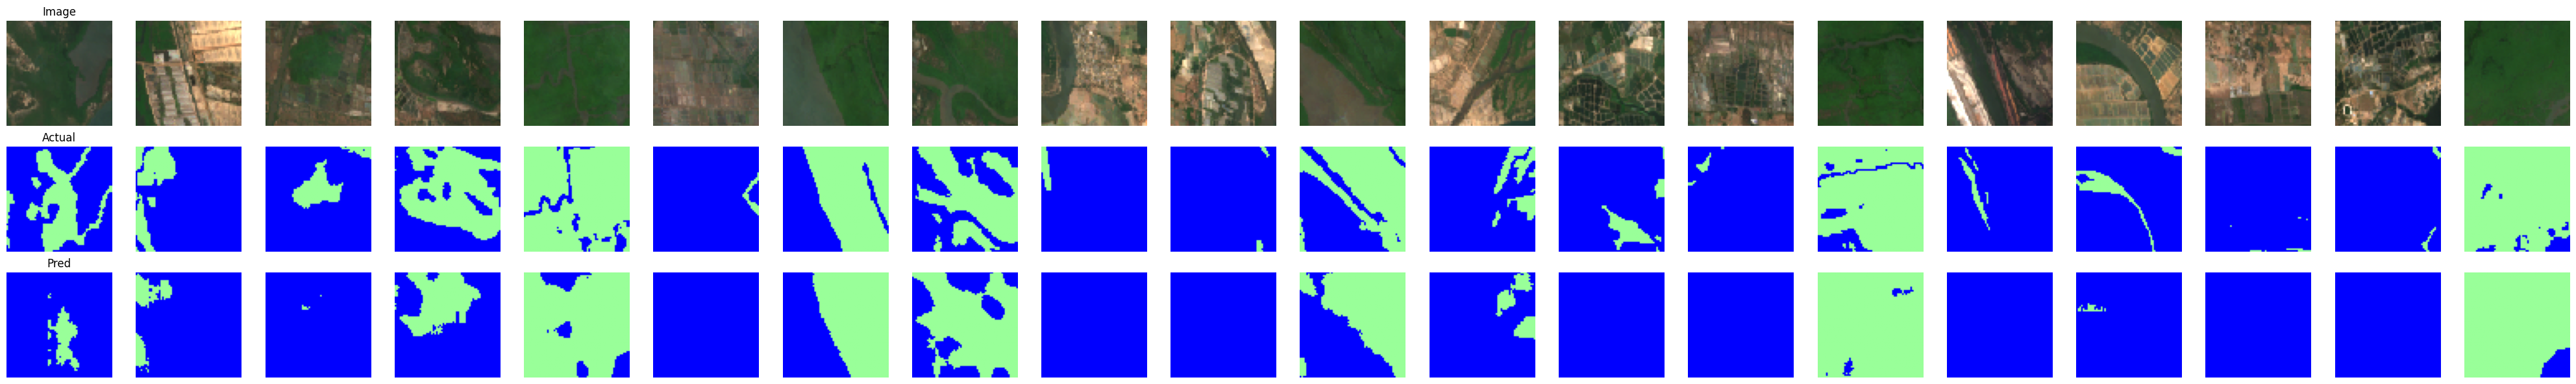

In [47]:
# Plot the predictions
plot_predictions(images_filtered, labels_filtered, preds_filtered)

In [48]:
def compute_segmentation_metrics(y_true, y_pred, num_classes):
    """
    y_true and y_pred: shape (H, W) or (N, H, W), dtype=int
    num_classes: total number of classes in your label space
    """
    if y_true.ndim == 3:
        y_true = y_true.reshape(-1)
        y_pred = y_pred.reshape(-1)
    else:
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
    iou_per_class = intersection / np.maximum(union, 1)  # avoid div by 0
    miou = np.mean(iou_per_class)

    pixel_accuracy = np.sum(intersection) / np.sum(cm)
    
    return {
        "iou_per_class": iou_per_class,
        "mean_iou": miou,
        "pixel_accuracy": pixel_accuracy,
        "confusion_matrix": cm
    }


In [49]:
# Example: binary segmentation output
# y_true, y_pred = arrays of shape (512, 512) or (batch_size, 512, 512)
metrics = compute_segmentation_metrics(labels, preds, num_classes=2)

print("Mean IoU:", metrics["mean_iou"])
print("IoU per class:", metrics["iou_per_class"])
print("Pixel Accuracy:", metrics["pixel_accuracy"])


Mean IoU: 0.8222133728234926
IoU per class: [0.99323221 0.65119454]
Pixel Accuracy: 0.993316650390625
